In [1]:
%matplotlib inline
from copy import deepcopy
from moseq2_extract.cli import extract
from moseq2_extract.extract.proc import clean_frames # this will clean frames similar to the pre-processing used in the extraction library
from moseq2_batch.util import recursive_find_h5s # convenience function for finding extracted data
import h5py
import numpy as np
import matplotlib.pyplot as plt
import joblib
import sklearn.model_selection
import sklearn.ensemble
import os
import cv2

In [2]:
max_frames=4e5 # max number of frames to use (so we don't spend all day training, performance anecdotally saturates around 1e5)

### First grab corrected frames, then we'll make a dataset with x and y flips

In [3]:
cd /Volumes/LaCie/scratch/test_data/

/Volumes/LaCie/scratch/test_data


In [4]:
h5s = recursive_find_h5s(root_dir=os.getcwd()) # this is just a convenience function to find h5s
print(h5s[0])

['/Volumes/LaCie/scratch/test_data/session_20180503101758/proc/results_00.h5', '/Volumes/LaCie/scratch/test_data/session_20180503112433/proc/results_00.h5']


In [5]:
dsets = [h5py.File(h5)['frames'] for h5 in h5s[0]]
data = [dset.value for dset in dsets]
merged_data = np.concatenate(data, axis=0)
print(merged_data.shape)

(161953, 80, 80)


In [6]:
# these are the current defaults for cleaning frames in MoSeq2-extract
clean_parameters = {
    'iters_tail': 1,
    'strel_tail': cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9)),
    'prefilter_space': (3,)}

In [7]:
clean_merged_data=clean_frames(merged_data, **clean_parameters)

Cleaning frames: 100%|██████████| 161953/161953 [00:14<00:00, 11438.55it/s]


### If there are flips, make a list of frames with flips (mouse facing left)

In [8]:
flips = [range(dsets[0].shape[0]+1772,dsets[0].shape[0]+1841),
         range(dsets[0].shape[0]+3588,dsets[0].shape[0]+3634),
         range(dsets[0].shape[0]+80854,dsets[0].shape[0]+dsets[1].shape[0])]
flip_idx = np.concatenate([list(flip) for flip in flips])

### Correct the flips 

In [9]:
corrected_data = deepcopy(clean_merged_data)

In [10]:
corrected_data[flip_idx] = np.flip(corrected_data[flip_idx], axis=2)

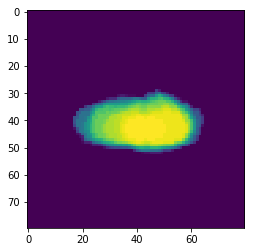

In [11]:
plt.imshow(corrected_data[flip_idx[10]])

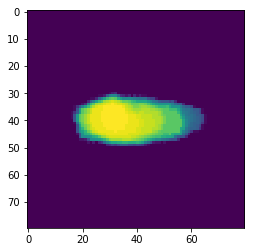

In [12]:
plt.imshow(corrected_data[200])

### Make 4 datasets: (1) corrected data, (2) x-axis flipped, (3) y-axis flipped, (4) x and y-axis flipped

The corrected data and y-axis flipped are **correct** examples, and x-axis flipped and x and y-axis flipped are **incorrect** examples

In [13]:
data_xflip=np.flip(corrected_data,axis=2)
data_yflip=np.flip(corrected_data,axis=1)
data_xyflip=np.flip(data_yflip,axis=2)

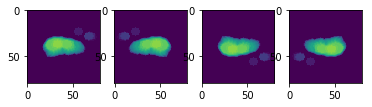

In [14]:
fig, axes=plt.subplots(1,4)
axes[0].imshow(corrected_data[0,...],vmin=0,vmax=40)
axes[1].imshow(data_xflip[0,...],vmin=0,vmax=40)
axes[2].imshow(data_yflip[0,...],vmin=0,vmax=40)
axes[3].imshow(data_xyflip[0,...],vmin=0,vmax=40)

In [15]:
npixels=corrected_data.shape[1]*corrected_data.shape[2]
ntrials=corrected_data.shape[0]

In [16]:
x=np.vstack((data_xflip.reshape((-1,6400)),data_xyflip.reshape((-1,6400)),
             data_yflip.reshape((-1,6400)),corrected_data.reshape((-1,6400))))

### For the labels we predict, 1 indicates a flip (facing left) 0 is not-flipped (facing right)

In [17]:
y=np.concatenate((np.ones((ntrials*2,)),np.zeros((ntrials*2,)))) # class 1 is x flipped data

In [18]:
print(x.shape)
print(y.shape)

(647812, 6400)
(647812,)


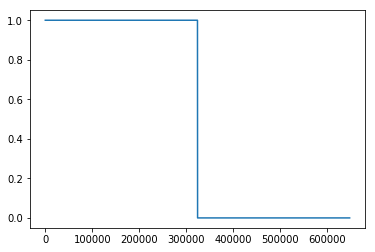

In [19]:
plt.plot(y)

### Evaluate performance using held-out data

In [20]:
x_train,x_test,y_train,y_test=\
    sklearn.model_selection.train_test_split(x,y,test_size=.25,random_state=0)

In [21]:
%%time 
clf=sklearn.ensemble.RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1,
                                            max_depth=10,class_weight='balanced',
                                            warm_start=False)
clf.fit(x_train,y_train)

CPU times: user 48min 59s, sys: 13.9 s, total: 49min 13s
Wall time: 4min 40s


In [22]:
y_predict=clf.predict(x_test)
print('Performance: {0:3f}% correct'.format(np.mean(y_test==y_predict)*1e2))

Performance: 97.322680% correct


### For the final model, train on all available data

In [23]:
%%time
clf.fit(x,y)

CPU times: user 1h 1min 3s, sys: 17.8 s, total: 1h 1min 21s
Wall time: 5min 49s


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [24]:
# export using joblib, we pass this using moseq2-extract extract --flip-classifier flip_classifier_test.pkl
joblib.dump(clf,'flip_classifier_test.pkl')

['flip_classifier_test.pkl']